In [7]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision
from torchvision import transforms

In [10]:
SAMPLES_CSV = "data/samples_step1_person_limited.csv"
PROC_ROOT   = "data/processed_step2"
CKPT_PATH   = "data/step3_checkpoint.pth"

FIG_DIR = "figures"
GC_DIR  = "gradcam"
os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(GC_DIR, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
print("Checkpoint:", CKPT_PATH)

Device: cpu
Checkpoint: data/step3_checkpoint.pth


In [11]:
# Load trained checkpoint
ckpt = torch.load(CKPT_PATH, map_location=device)

idx_to_class = ckpt["idx_to_class"]
class_to_idx = ckpt["class_to_idx"]
classes = ckpt["classes"]

# Use condition stored in checkpoint
CONDITION = ckpt.get("condition", "motion_blur")
print("CONDITION:", CONDITION)

num_classes = len(classes)

# Rebuild ResNet18 architecture
model = torchvision.models.resnet18(weights=None)
model.fc = nn.Linear(model.fc.in_features, num_classes)
# Load trained weights
model.load_state_dict(ckpt["model_state_dict"])
model = model.to(device)
model.eval()

print("Loaded model. num_classes =", num_classes)

CONDITION: orig_full
Loaded model. num_classes = 6


In [12]:
df = pd.read_csv(SAMPLES_CSV)
df["img_file"] = df.apply(
    lambda r: f"{int(r.image_id)}_{int(r.ann_id)}.jpg",
    axis=1
)

df["cond_path"] = df["img_file"].apply(
    lambda f: os.path.join(PROC_ROOT, CONDITION, f)
)
df = df[df["cond_path"].apply(os.path.exists)].copy()

# Map category name to label index
df["label"] = df["category_name"].map(class_to_idx).astype(int)

# random subset used for Grad-CAM and evaluation.
SEED = ckpt.get("seed", 42)
val_df = df.sample(frac=0.2, random_state=SEED).reset_index(drop=True)

print("Total rows (condition exists):", len(df))
print("Val rows:", len(val_df))
print(val_df["size_group"].value_counts())


Total rows (condition exists): 600
Val rows: 120
size_group
small     43
large     41
medium    36
Name: count, dtype: int64


In [15]:
val_tf = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [22]:
# Gradient-weighted Class Activation Mapping
class GradCAM:
    """
    Uses the last convolutional block (layer4) of ResNet18.
    """
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None

        # Save forward activations
        def fwd_hook(m, inp, out):
            self.activations = out

        # Save backward gradients
        def bwd_hook(m, grad_in, grad_out):
            self.gradients = grad_out[0]

        self.target_layer.register_forward_hook(fwd_hook)
        self.target_layer.register_full_backward_hook(bwd_hook)

    def __call__(self, x, class_idx=None):
        self.model.zero_grad()
        logits = self.model(x)

        # Use predicted class if not specified
        if class_idx is None:
            class_idx = int(torch.argmax(logits, dim=1).item())

        score = logits[0, class_idx]
        score.backward(retain_graph=True)

        # Grad-CAM computation
        A = self.activations.detach()  # feature maps
        G = self.gradients.detach()    # gradients

        w = torch.mean(G, dim=(2,3), keepdim=True)
        cam = torch.sum(w * A, dim=1, keepdim=True)
        cam = torch.relu(cam)

        cam = cam[0,0].cpu().numpy()
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        return cam, class_idx

cam_fn = GradCAM(model, model.layer4)


I implemented Grad-CAM using the last convolutional block (layer4) of ResNet18. This layer is chosen because it preserves high-level semantic information while still maintaining spatial resolution.

During the forward pass, feature map activations from layer 4 are stored. During the backward pass, gradients of the predicted class score with respect to these feature maps are collected.

Grad-CAM is computed by three steps below.

1. Averaging the gradients across spatial dimensions to obtain channel-wise weights.
2. Taking a weighted sum of the feature maps using these weights.
3. Applying ReLU to focus only on features that positively influence the prediction.

The resulting heatmap highlights image regions that contribute most strongly to the model's decision for a give class.

In [17]:
def load_rgb(path):
    bgr = cv2.imread(path)
    if bgr is None:
        return None
    return cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

# Overlay Grad-CAM heatmap on original image
def overlay_cam(rgb, cam, alpha=0.45):
    H, W = rgb.shape[:2]
    cam_resized = cv2.resize(cam, (W, H))
    heat = cv2.applyColorMap(
        (cam_resized * 255).astype(np.uint8),
        cv2.COLORMAP_JET
    )
    heat = cv2.cvtColor(heat, cv2.COLOR_BGR2RGB)
    return (alpha * heat + (1 - alpha) * rgb).astype(np.uint8)

# Run a single forward pass and return predicted label index.
def predict_one(img_rgb):
    x = val_tf(img_rgb).unsqueeze(0).to(device)
    with torch.no_grad():
        pred = int(torch.argmax(model(x), dim=1).item())
    return pred

In [18]:
# Shuffle small-object samples
small_pool = val_df[val_df["size_group"]=="small"].sample(
    frac=1, random_state=0
)

correct, wrong = [], []

# Automatically select 3 correct + 3 incorrect predictions
for _, row in small_pool.iterrows():
    img_rgb = load_rgb(row["cond_path"])
    if img_rgb is None:
        continue

    pred = predict_one(img_rgb)
    gt = int(row["label"])

    if pred == gt and len(correct) < 3:
        correct.append((row, img_rgb, pred))
    if pred != gt and len(wrong) < 3:
        wrong.append((row, img_rgb, pred))

    if len(correct) >= 3 and len(wrong) >= 3:
        break

print("Selected correct:", len(correct), "wrong:", len(wrong))

Selected correct: 3 wrong: 3


In [19]:
# Save original image + Grad-CAM visualization.
def save_gradcam(examples, tag):
    for i, (row, img_rgb, pred) in enumerate(examples, start=1):
        x = val_tf(img_rgb).unsqueeze(0).to(device)
        cam, _ = cam_fn(x, class_idx=pred)
        over = overlay_cam(img_rgb, cam)

        gt_name = row["category_name"]
        pred_name = idx_to_class[pred]

        fig = plt.figure(figsize=(10,4))
        plt.subplot(1,2,1)
        plt.imshow(img_rgb); plt.axis("off")
        plt.title(f"{tag} ({CONDITION})\nGT={gt_name} Pred={pred_name}")

        plt.subplot(1,2,2)
        plt.imshow(over); plt.axis("off")
        plt.title("Grad-CAM")

        out_path = os.path.join(
            GC_DIR,
            f"{tag}_{i}_{CONDITION}_gt-{gt_name}_pred-{pred_name}.png"
        )
        plt.tight_layout()
        plt.savefig(out_path, dpi=200)
        plt.close(fig)

        print("Saved:", out_path)

save_gradcam(correct, "small_correct")
save_gradcam(wrong, "small_wrong")

Saved: gradcam/small_correct_1_orig_full_gt-bicycle_pred-bicycle.png
Saved: gradcam/small_correct_2_orig_full_gt-truck_pred-truck.png
Saved: gradcam/small_correct_3_orig_full_gt-person_pred-person.png
Saved: gradcam/small_wrong_1_orig_full_gt-truck_pred-bus.png
Saved: gradcam/small_wrong_2_orig_full_gt-person_pred-motorcycle.png
Saved: gradcam/small_wrong_3_orig_full_gt-car_pred-person.png


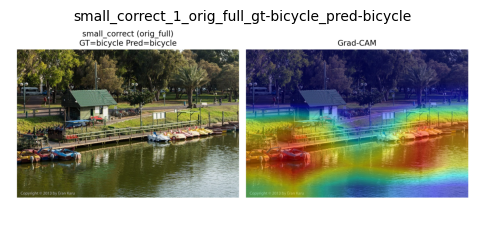

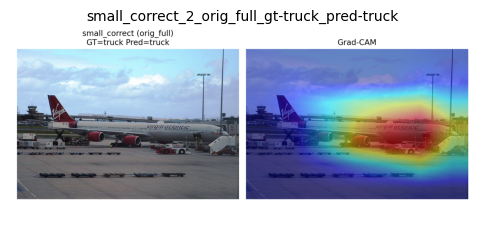

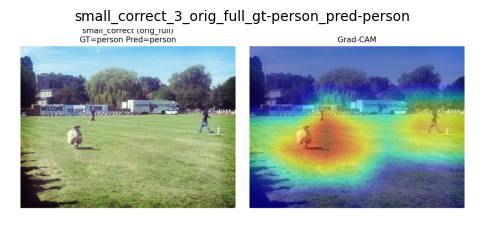

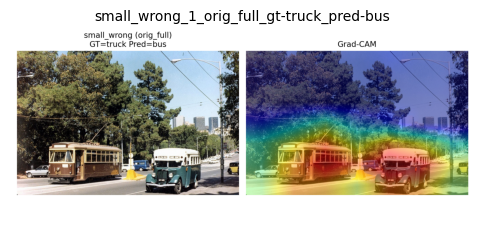

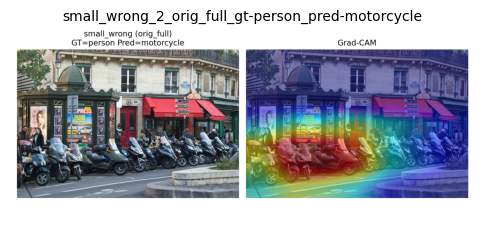

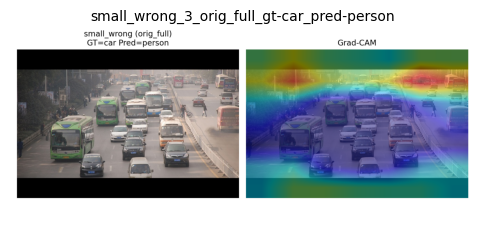

In [21]:
gradcam_files = [
    "gradcam/small_correct_1_orig_full_gt-bicycle_pred-bicycle.png",
    "gradcam/small_correct_2_orig_full_gt-truck_pred-truck.png",
    "gradcam/small_correct_3_orig_full_gt-person_pred-person.png",
    "gradcam/small_wrong_1_orig_full_gt-truck_pred-bus.png",
    "gradcam/small_wrong_2_orig_full_gt-person_pred-motorcycle.png",
    "gradcam/small_wrong_3_orig_full_gt-car_pred-person.png",
]

for path in gradcam_files:
    img_bgr = cv2.imread(path)
    if img_bgr is None:
        print("Failed to load:", path)
        continue

    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(6, 4))
    plt.imshow(img_rgb)
    plt.axis("off")

    title = os.path.basename(path).replace(".png", "")
    plt.title(title, fontsize=10)

    plt.show()

The Grad-CAM visualizations reveal clear differences between correct and incorrect
predictions for small objects.

For correctly classified examples, the activation maps tend to align with
the actual object regions, such as the bicycle, truck, or person. Although the objects are small, the model still focuses on meaningful visual cues
like object contours or characteristic shapes.


In contrast, for misclassified examples, the attention is more dispersed
or shifted toward surrounding context. For example, the model often focuses on background structures, nearby objects, or repeated patterns instead of the true target object. This behavior is especially visible in crowded scenes, where multiple similar objects appear together.

These results suggest that, for small objects, the CNN relies heavily on
contextual information rather than precise object localization. This explains why small objects are more vulnerable to misclassification, even under the original (non-degraded) condition.

## Final Interpretation

This study reveals a clear and consistent performance gap across object sizes. Large objects remain relatively robust under all conditions, while small objects
suffer significant accuracy degradation, especially under downscaling and motion blur.

Object-centric cropping leads to a notable improvement in small-object accuracy,
indicating that background clutter and limited effective resolution are major
contributors to failure. When the object occupies only a small portion of the image, its discriminative features are easily overwhelmed by surrounding context.

Grad-CAM visualizations further support this observation. For correct predictions, the model’s attention is concentrated on the object itself,
even when the object is small. In contrast, misclassified cases frequently show
diffuse or misplaced attention, with the model focusing on background regions or
neighboring objects rather than the true target.

Overall, these results suggest that CNNs struggle with small objects because
object-level signals become weak after repeated spatial downsampling.
As a result, the model increasingly relies on contextual cues, which may be
misleading in complex scenes.

### Why CNNs struggle with Small Objects

The underlying reason for this behavior lies in the architectural properties of CNNs. Convolutional backbones progressively reduce spatial resolution through strided convolutions and pooling operations. While this is beneficial for capturing high-level semantics, it disproportionately harms small objects whose features may vanish or become indistinguishable at deeper layers.

Additionally, standard CNN training encourages global discriminative patterns. When object features are weak, the network naturally exploits stable background
correlations present in the dataset, leading to context-biased predictions. This explains why Grad-CAM highlights background regions in many failure cases.

### How can this be improved?

First, preserving higher spatial resolution through multi-scale feature representations (e.g., feature pyramid networks) can help retain fine-grained details that are critical for small-object recognition.

Second, object-centric preprocessing such as cropping or attention-guided zooming can reduce background dominance and strengthen object-level signals, as shown by the large performance gain under the cropped condition.

Third, lightweight contrast-enhancing preprocessing methods like CLAHE can improve small-object recognition without retraining the model, by amplifying weak local object cues and making them more distinguishable from background context.